# Grid Hydrometeor Phase data using PyART
Processing is same as [SQUIRE notebook](https://github.com/ARM-Development/sail-xprecip-radar/blob/main/notebooks/VAP/nearest-neighbor-interpolation.ipynb)

In [67]:
import pyart
import matplotlib.pyplot as plt
import numpy as np
import glob
from pathlib import Path
import xradar as xd


In [68]:
files = sorted(glob.glob("/gpfs/wolf2/arm/atm124/proj-shared/HydroPhase/202208/*.nc"))
filename= files[-1480]
filename

'/gpfs/wolf2/arm/atm124/proj-shared/HydroPhase/202208/gucxprecipradarcmacppihpS2.c1.20220825.194043.nc'

In [69]:
radar = pyart.io.read(filename)

/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/pyart/io/cfradial.py:424: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/pyart/io/cfradial.py:424: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


In [70]:
# Define color mapping
colors = {
    'Unclassified': '#008837',  # Dark Green
    'Rain': '#a6dba0',          # Light Green
    'Snow': '#c2a5cf',          # Light Purple
    'Graupel and Hail': '#7b3294',  # Dark Purple
    'Wet Snow and Melting Hail': '#FFC107',  # Yellow
}

# Create a custom colormap for categorical data
cmap = ListedColormap([colors['Unclassified'], colors['Rain'], colors['Snow'], colors['Graupel and Hail'], colors['Wet Snow and Melting Hail']])


In [71]:

# Setup a Helper Function and Configure our Grid

def compute_number_of_points(extent, resolution):
    """
    Create a helper function to determine number of points
    """
    return int((extent[1] - extent[0])/resolution)

# Grid extents in meters
z_grid_limits = (500.,5_000.)
y_grid_limits = (-20_000.,20_000.)
x_grid_limits = (-20_000.,20_000.)

# Grid resolution in meters
grid_resolution = 250

x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)


18 160 160


In [72]:

#Create our Grid using grid_from_radars

grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  method='nearest'
                                 )


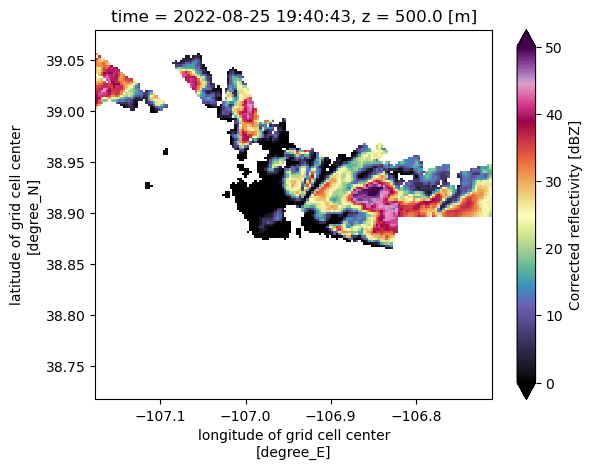

In [73]:
ds = grid.to_xarray()
ds.corrected_reflectivity.isel(z=0).plot(x='lon', y='lat', vmin=0, vmax=50, 
                                         cmap='pyart_ChaseSpectral')

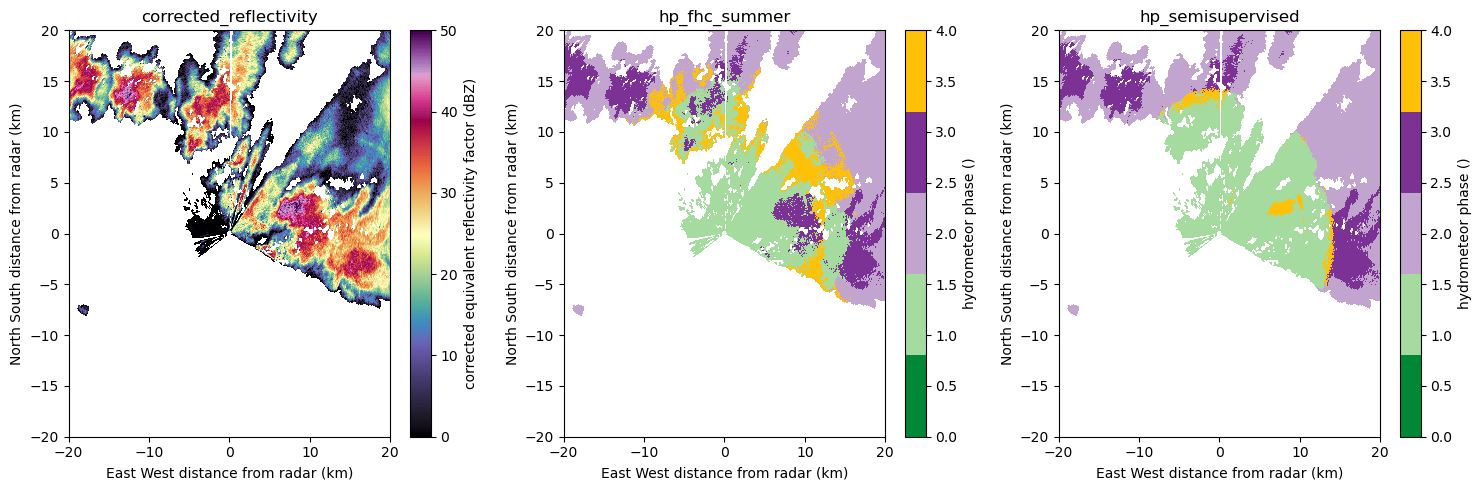

In [74]:
# Create RadarDisplay object
display = pyart.graph.RadarDisplay(radar)

# Create figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot corrected_reflectivity
ax = axes[0]
display.plot('corrected_reflectivity', 3, ax=ax, title="corrected_reflectivity", 
             cmap='pyart_ChaseSpectral', vmin=0, vmax=50)
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

# Plot hp_fhc_summer
ax = axes[1]
display.plot('hp_fhc_summer', 3, ax=ax, title="hp_fhc_summer", cmap=cmap)
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

# Plot hp_semisupervised
ax = axes[2]
display.plot('hp_semisupervised', 3, ax=ax, title="hp_semisupervised", cmap=cmap)
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

plt.tight_layout()
plt.show()

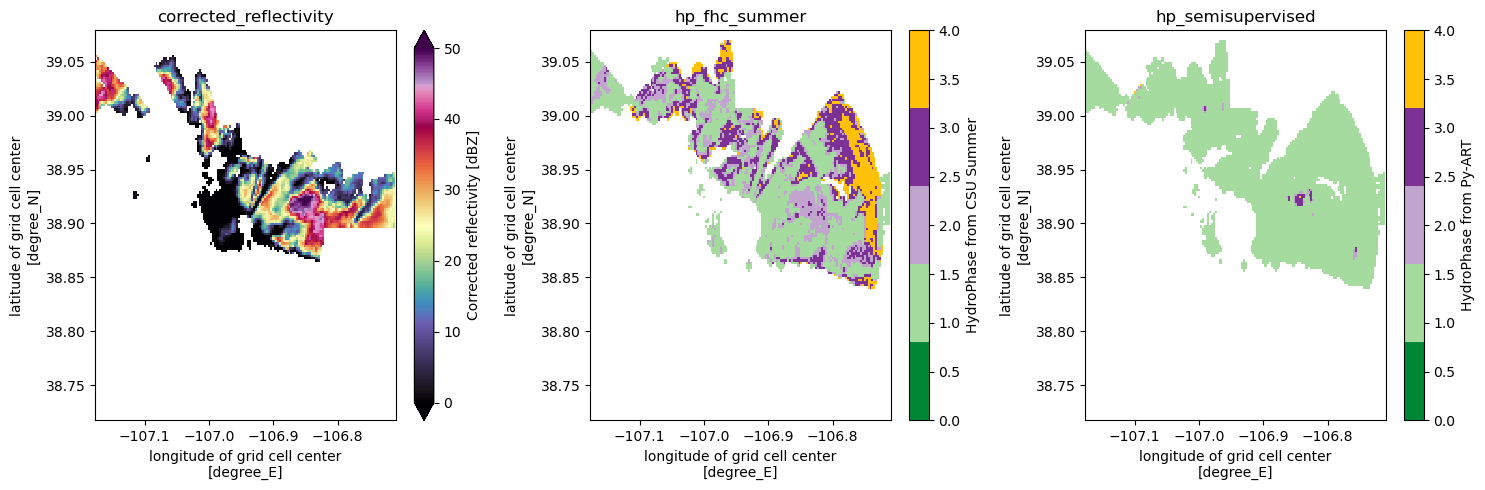

In [75]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot corrected_reflectivity
ax = axes[0]
ds.corrected_reflectivity.isel(z=0).plot(x='lon', y='lat', ax=ax, vmin=0, vmax=50, cmap='pyart_ChaseSpectral')
ax.set_title("corrected_reflectivity")

# Plot hp_fhc_summer
ax = axes[1]
ds.hp_fhc_summer.isel(z=2).plot(x='lon', y='lat', ax=ax, vmin=0, cmap=cmap)
ax.set_title("hp_fhc_summer")

# Plot hp_semisupervised
ax = axes[2]
ds.hp_semisupervised.isel(z=2).plot(x='lon', y='lat', ax=ax, vmin=0, cmap=cmap)
ax.set_title("hp_semisupervised")

# Show plot
plt.tight_layout()
plt.show()

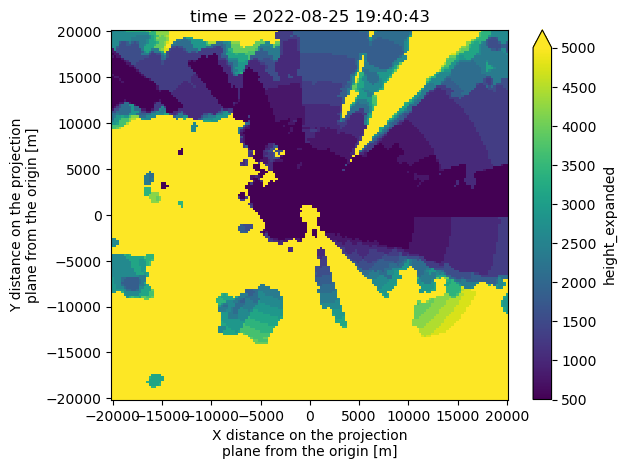

In [76]:
ds["height_expanded"] = (ds.z * (ds.corrected_reflectivity/ds.corrected_reflectivity)).fillna(10_000)
min_index = ds.height_expanded.argmin(dim='z',
                                      skipna=True)
ds.height_expanded.isel(z=min_index).plot(vmin=500,
                                          vmax=5000);

In [77]:
hp_fields = [var for var in list(ds.variables) if "hp" in var]
hp_fields

['hp_semisupervised', 'hp_fhc_summer']

In [78]:
subset_ds = ds[hp_fields].isel(z=min_index)

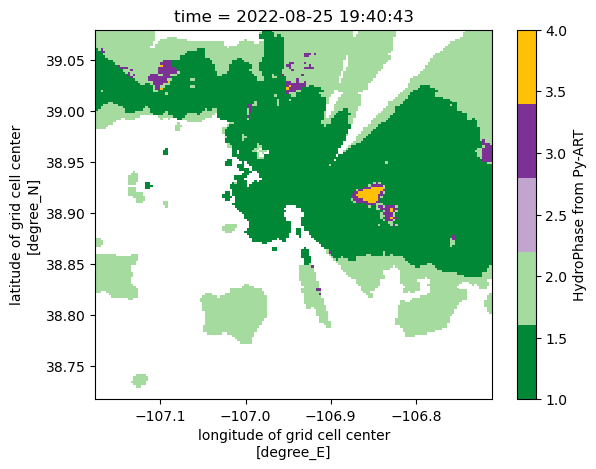

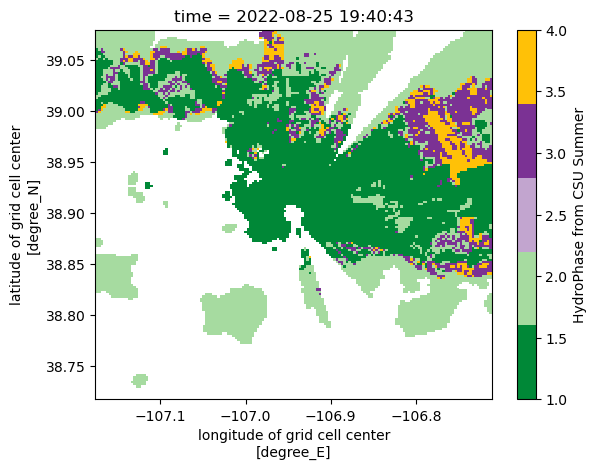

In [79]:
for hp_field in hp_fields:
    subset_ds[hp_field].plot(x='lon',
                               y='lat',
                               cmap=cmap)
    plt.show()
    plt.close()